In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv("") # logs_<>.csv file for activity anomaly

# Convert stringified lists to actual Python lists
df["eventually_follows"] = df["eventually_follows"].apply(ast.literal_eval)
df["unique_activities"] = df["unique_activities"].apply(ast.literal_eval)

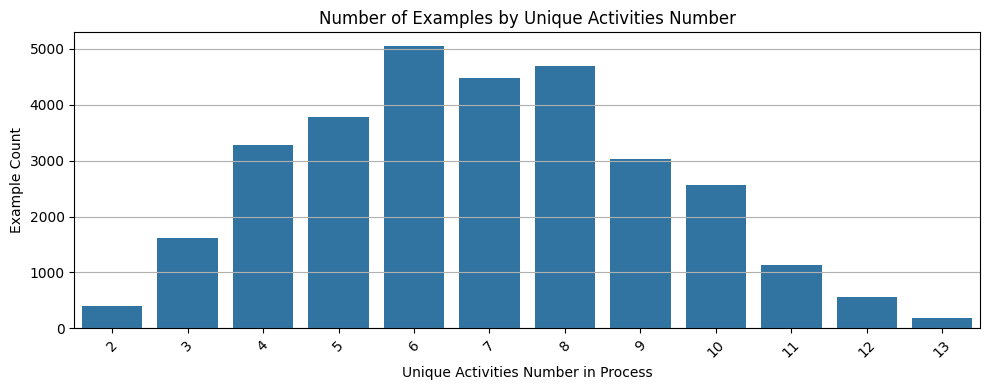

In [4]:
df["num_unique_activities"] = df["unique_activities"].apply(len)

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="num_unique_activities", order=sorted(df["num_unique_activities"].unique()))


plt.title("Number of Examples by Unique Activities Number")
plt.xlabel("Unique Activities Number in Process")
plt.ylabel("Example Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [ ]:
df["num_unique_activities"] = df["unique_activities"].apply(len)

# Classify by process size (arbitrary threshold)
df["process_size"] = df["num_unique_activities"].apply(
    lambda x: "2-4" if x <= 4 else "5-7" if x <= 7 else "8-10" if x <= 10 else "11-13"
)
process_order = ["2-4", "5-7", "8-10", "11-13"]
df["process_size"] = pd.Categorical(df["process_size"], categories=process_order, ordered=True)

# Compute F1 per process size
f1_scores = []
counts = []

for size in process_order:
    group = df[df["process_size"] == size]
    if group["true_label"].nunique() > 1:
        f1 = f1_score(group["true_label"], group["prediction"], average='macro', zero_division=0)
    else:
        f1 = float('nan')
    f1_scores.append(f1)
    counts.append(len(group))

# Build DataFrame for plotting
f1_df = pd.DataFrame({
    "process_size": process_order,
    "f1_score": f1_scores,
    "count": counts
})

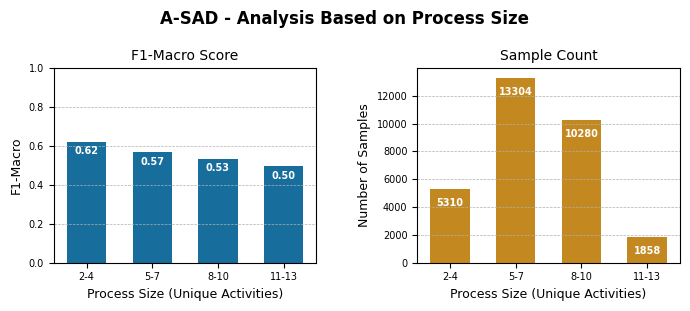

In [ ]:
# plot: A-SAD - Analysis Based on Process Size

pastel_palette = sns.color_palette("colorblind")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle("A-SAD - Analysis Based on Process Size", fontsize=12, weight="bold", y=1.02)

# Left plot: F1 Scores
sns.barplot(data=f1_df, x="process_size", y="f1_score", ax=ax1, color=pastel_palette[0], width=0.6)

for p in ax1.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 0.15:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height - 0.05),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height + 0.02),
                         ha='center', va='bottom', fontsize=7, color="blue")

ax1.set_title("F1-Macro Score", fontsize=10)
ax1.set_ylabel("F1-Macro", fontsize=9)
ax1.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax1.set_ylim(0, 1)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)

# Right plot: Sample Counts
sns.barplot(data=f1_df, x="process_size", y="count", ax=ax2, color=pastel_palette[1], width=0.6)

for p in ax2.patches:
    height = p.get_height()
    if not pd.isna(height) and height >= 0:
        if height > 500:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height - 1000),
                         ha='center', va='center', fontsize=7, color="white", weight="bold")
        else:
            ax2.annotate(f"{int(height)}",
                         (p.get_x() + p.get_width() / 2., height + 50),
                         ha='center', va='bottom', fontsize=7, color="red")

ax2.set_title("Sample Count", fontsize=10)
ax2.set_ylabel("Number of Samples", fontsize=9)
ax2.set_xlabel("Process Size (Unique Activities)", fontsize=9)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

# Slightly wider distance between subplots
plt.tight_layout(rect=[0, 0, 1, 1.05], w_pad=3)  
plt.show()

/tmp/ipykernel_3557185/2341510667.py:75: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#949494'` for the same effect.

  sns.barplot(data=metrics_melted, x="Label", y="Score", hue="Metric", ax=ax2, color=palette[7])


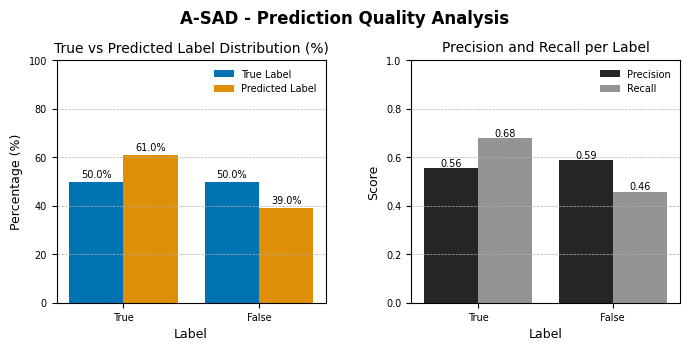

In [ ]:
# plot: A-SAD - Prediction Quality Analysis

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score

# --- True vs Predicted Label Distribution ---
true_counts = df["true_label"].value_counts(normalize=True) * 100
pred_counts = df["prediction"].value_counts(normalize=True) * 100

counts_df = pd.DataFrame({
    "True Label (%)": true_counts,
    "Predicted Label (%)": pred_counts
}).reset_index().rename(columns={"index": "Label"})

counts_df["Label"] = counts_df["Label"].astype(str) 

true_label_percents = counts_df.set_index("Label").loc["True"]
false_label_percents = counts_df.set_index("Label").loc["False"]

true_values = [true_label_percents["True Label (%)"], false_label_percents["True Label (%)"]]
pred_values = [true_label_percents["Predicted Label (%)"], false_label_percents["Predicted Label (%)"]]

# --- Precision and Recall ---
precision_true = precision_score(df["true_label"], df["prediction"], pos_label=True)
recall_true = recall_score(df["true_label"], df["prediction"], pos_label=True)
precision_false = precision_score(df["true_label"], df["prediction"], pos_label=False)
recall_false = recall_score(df["true_label"], df["prediction"], pos_label=False)

metrics_df = pd.DataFrame({
    "Label": ["True", "False"],
    "Precision": [precision_true, precision_false],
    "Recall": [recall_true, recall_false]
})
metrics_melted = metrics_df.melt(id_vars="Label", value_vars=["Precision", "Recall"], 
                                 var_name="Metric", value_name="Score")

palette = sns.color_palette("colorblind")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.3))
fig.suptitle("A-SAD - Prediction Quality Analysis", fontsize=12, weight="bold", y=1.05)

# Left plot: True vs Predicted Label Distribution
bar_width = 0.4
labels = ["True", "False"]

ax1.bar([x - bar_width/2 for x in range(len(labels))], true_values, 
        width=bar_width, label="True Label", color=palette[0])
ax1.bar([x + bar_width/2 for x in range(len(labels))], pred_values, 
        width=bar_width, label="Predicted Label", color=palette[1])

for i, (true_val, pred_val) in enumerate(zip(true_values, pred_values)):
    ax1.text(i - bar_width/2, true_val + 1, f"{true_val:.1f}%", ha='center', va='bottom', fontsize=7)
    ax1.text(i + bar_width/2, pred_val + 1, f"{pred_val:.1f}%", ha='center', va='bottom', fontsize=7)

ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels)
ax1.set_title("True vs Predicted Label Distribution (%)", fontsize=10)
ax1.set_xlabel("Label", fontsize=9)
ax1.set_ylabel("Percentage (%)", fontsize=9)
ax1.set_ylim(0, 100)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)
ax1.tick_params(axis='both', labelsize=7)

ax1.legend(loc="upper right", fontsize=7, frameon=False)

# Right plot: Precision and Recall
sns.barplot(data=metrics_melted, x="Label", y="Score", hue="Metric", ax=ax2, color=palette[7])

for p in ax2.patches:
    height = p.get_height()
    if height > 1e-3:
        ax2.annotate(f"{height:.2f}", 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', fontsize=7)

ax2.set_title("Precision and Recall per Label", fontsize=10)
ax2.set_ylabel("Score", fontsize=9)
ax2.set_xlabel("Label", fontsize=9)
ax2.set_ylim(0, 1)
ax2.grid(axis="y", linestyle="--", linewidth=0.5)
ax2.tick_params(axis='both', labelsize=7)

ax2.legend(loc="upper right", fontsize=7, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 1.1], w_pad=3)
plt.show()